# [Scratchpad of Analysis]

Exploration of the detection analysis.... 
Scratchpad

Later to be integrated as pipeline

# Setup

## Library import
We import all the required Python libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys
import joblib
from os import path

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Common things
# from sklearn.metrics import classification_report
# from scipy import stats

# Visualizations
# import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("white") # darkgrid, whitegrid, dark, white, and ticks
# plt.figure(figsize=(7, 7))

# Autoreload extension
# if 'autoreload' not in get_ipython().extension_manager.loaded:
#     %load_ext autoreload
    
# %autoreload 2

In [ ]:
# Examples seaborn
# with sns.axes_style("whitegrid"):
#     fig, axis = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
#     fig.suptitle(f'Position distribution on splits')
#     sns.boxplot(ax=axis[0], data=df_prep, y='event', x='ith_pos', order=event_label_map.values())
#     sns.boxplot(ax=axis[1], data=pd.read_pickle(path.join(DATA_PATH, "stage2_test.pkl") ), y='event', x='ith_pos', order=event_label_map.values())

## Local library import
We import all the required local libraries libraries

In [3]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries
# add project folders so local libraries can be imported
sys.path.insert(1, os.path.join(os.getcwd()  , '..'))
sys.path.insert(1, os.path.join(os.getcwd()  , '../src'))

# Import local libraries
# from plibs.utils import corrstats
# from src.plibs.utils import plots as myplots

In [4]:
# notebook misc functions
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def displayAll(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):	
        display(df)  

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [88]:
def normalize(df:pd.DataFrame, cols = [], normtype="minmax"):
    # copy the data
    df_min_max_scaled = df.copy()
    
    # apply normalization techniques
    for column in (cols or df.columns): # df_min_max_scaled.columns:
        if normtype=='minmax':
            df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
        elif normtype=='max':
            df_min_max_scaled[column] = (df_min_max_scaled[column] ) / (df_min_max_scaled[column].abs().max())    
        elif normtype=="zscale":
                df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].mean()) / df_min_max_scaled[column].std()   
    
    # view normalized data
    return df_min_max_scaled

In [136]:
def counts_for_plot(df:pd.DataFrame, var1, var2, relative_to_var1_value:str=None):
    dftmp = df[[var1, var2]].melt(id_vars=[var1])
    dftmp = dftmp.groupby(by=[var1, "value"]).count().reset_index()    
    if relative_to_var1_value:
        anchor_values = dict(dftmp[dftmp[var1]==relative_to_var1_value][["value", "variable"]].values)        
        dftmp["variable"] = dftmp.apply(lambda e: e["variable"] - anchor_values.get(e["value"], 0), axis=1)
        dftmp = ( dftmp.query(f"{var1}!='{relative_to_var1_value}'") ) # remove anchor entries
    return dftmp

In [271]:
def proportion_plot(labels, counts, **kwargs):    
    palette_color = sns.color_palette('muted') 
    plt.pie(counts, labels=labels, colors=palette_color, autopct='%.0f%%')  

In [195]:
def hex_to_rgb(hex):
  return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))


# Scratchpad


## Load data

In [14]:
ds_txts = pd.read_csv("../data/data/detection_dataset/20231030_145712_databricks-dolly_size-1000_melted_stats.tsv", sep="\t", index_col=[0])

print(f"{ds_txts.shape} -> {ds_txts.columns}")
ds_txts.head()

(8000, 35) -> Index(['instruction', 'context', 'category', 'data_id', 'model', 'response',
       'id', 'readability_flesch_kincaid_score', 'readability_flesch_score',
       'readability_gunning_fog_score', 'readability_coleman_liau_score',
       'readability_dale_chall_score', 'readability_ari_score',
       'readability_linsear_write_score', 'stats_avg_word_length',
       'stats_avg_sentence_length', 'stats_avg_words_per_sentence',
       'stats_percent_vowels', 'stats_percent_consonants',
       'stats_percent_punctuation', 'stats_percent_stopwords',
       'stats_num_words', 'stats_num_sentences', 'stats_percent_unique_words',
       'stats_percent_long_words', 'spacy_percent_nouns',
       'spacy_percent_verbs', 'spacy_percent_adjectives',
       'detector_radar_vicuna_7B_label',
       'detector_radar_vicuna_7B_human_confidence_score',
       'detector_radar_vicuna_7B_ai_confidence_score',
       'detector_chatgpt_qa_detector_score',
       'detector_chatgpt_qa_detector_label'

,instruction,context,category,data_id,model,response,id,readability_flesch_kincaid_score,readability_flesch_score,readability_gunning_fog_score,readability_coleman_liau_score,readability_dale_chall_score,readability_ari_score,readability_linsear_write_score,stats_avg_word_length,stats_avg_sentence_length,stats_avg_words_per_sentence,stats_percent_vowels,stats_percent_consonants,stats_percent_punctuation,stats_percent_stopwords,stats_num_words,stats_num_sentences,stats_percent_unique_words,stats_percent_long_words,spacy_percent_nouns,spacy_percent_verbs,spacy_percent_adjectives,detector_radar_vicuna_7B_label,detector_radar_vicuna_7B_human_confidence_score,detector_radar_vicuna_7B_ai_confidence_score,detector_chatgpt_qa_detector_score,detector_chatgpt_qa_detector_label,detector_xlmr_chatgptdetect_noisy_score,detector_xlmr_chatgptdetect_noisy_label
0,What are the best selling albums of all time? ...,NaN,brainstorming,81fd19bd675d4e048a2f308d53a0bf44,human,Best selling albums of all time:\n\n- Michael ...,dc30b6dce21c49cdbb36b17d95cc4e4e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.534483,378.0,58.0,0.267196,0.338624,0.068783,0.103448,58.0,1.0,0.896552,0.206897,0.043011,0.021505,0.032258,AI-generated,0.374648,0.625352,0.999768,LABEL_0,0.962242,HUMAN
1,"Given this paragraph about magnesium, what is ...",Elemental magnesium is a gray-white lightweigh...,closed_qa,d8b6f490829241e5a4a25140aafeda36,human,The melting point of magnesium is 650 °C.,72dac16b8c4b423e82cd048f02edd471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.250000,20.0,4.5,0.268293,0.390244,0.024390,0.250000,8.0,2.0,1.000000,0.125000,0.400000,0.000000,0.000000,AI-generated,0.002299,0.997701,0.989739,LABEL_0,0.999998,HUMAN
2,How do I pick the best bananas?,NaN,general_qa,c95dc390011b427ebd791458d33807fb,human,It depends on when you want to eat them. If yo...,967e78499907437bafc05727d21c81a0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.875000,53.6,12.0,0.305147,0.448529,0.025735,0.464286,56.0,5.0,0.714286,0.053571,0.095238,0.142857,0.095238,AI-generated,0.005447,0.994553,0.996650,LABEL_0,0.999998,HUMAN
3,Extract the teams that Bob Sanders played thro...,"Demond ""Bob"" Sanders (born February 24, 1981) ...",information_extraction,be55b8cc108f437296914a6a7bbe4565,human,"Iowa Hawkeyes, Indianapolis Colts, San Diego C...",5b6736d2c197455b8f55f08c865dc8d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.714286,53.0,7.0,0.320755,0.396226,0.037736,0.000000,7.0,1.0,1.000000,0.428571,0.000000,0.000000,0.000000,AI-generated,0.000849,0.999151,0.994716,LABEL_0,0.990737,HUMAN
4,Who was the 27th president of the United State...,NaN,open_qa,ce1bc1c0a9ef48e0856fcdd32fca3893,human,William Howard Taft was the 27th president of ...,c244a96767444e87a1024c7669e7bc0e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.533333,40.5,8.0,0.231707,0.402439,0.012195,0.400000,15.0,2.0,0.933333,0.066667,0.062500,0.000000,0.062500,AI-generated,0.001472,0.998528,0.975979,LABEL_0,0.999958,CHATGPT


In [70]:
ds_attitude = pd.read_csv(path.join("..", "out", "merged_fmt.tsv"), sep="\t", index_col=[0])
print(f"{ds_attitude.shape} -> {ds_attitude.columns}")
ds_attitude.head()

(8000, 32) -> Index(['emotion_admiration', 'emotion_amusement', 'emotion_anger',
       'emotion_annoyance', 'emotion_approval', 'emotion_caring',
       'emotion_confusion', 'emotion_curiosity', 'emotion_desire',
       'emotion_disappointment', 'emotion_disapproval', 'emotion_disgust',
       'emotion_embarrassment', 'emotion_excitement', 'emotion_fear',
       'emotion_gratitude', 'emotion_grief', 'emotion_joy', 'emotion_love',
       'emotion_nervousness', 'emotion_optimism', 'emotion_pride',
       'emotion_realization', 'emotion_relief', 'emotion_remorse',
       'emotion_sadness', 'emotion_surprise', 'emotion_neutral',
       'irony_non_irony', 'irony_irony', 'convincingness_convincing',
       'convincingness_non_convincing'],
      dtype='object')


,emotion_admiration,emotion_amusement,emotion_anger,emotion_annoyance,emotion_approval,emotion_caring,emotion_confusion,emotion_curiosity,emotion_desire,emotion_disappointment,emotion_disapproval,emotion_disgust,emotion_embarrassment,emotion_excitement,emotion_fear,emotion_gratitude,emotion_grief,emotion_joy,emotion_love,emotion_nervousness,emotion_optimism,emotion_pride,emotion_realization,emotion_relief,emotion_remorse,emotion_sadness,emotion_surprise,emotion_neutral,irony_non_irony,irony_irony,convincingness_convincing,convincingness_non_convincing
0,0.002117,0.000175,0.000084,0.000299,0.002078,0.000040,0.000109,0.000109,0.000070,0.000221,0.000150,0.000125,0.000050,0.000631,0.000080,0.000085,0.000027,0.000487,0.000192,0.000023,0.000128,0.000086,0.000670,0.000050,0.000017,0.000102,0.000178,0.991616,0.970296,0.029704,0.857564,0.142436
1,0.000200,0.000080,0.000066,0.000281,0.001549,0.000030,0.000214,0.000133,0.000049,0.000130,0.000194,0.000125,0.000028,0.000081,0.000058,0.000027,0.000013,0.000055,0.000074,0.000015,0.000107,0.000012,0.000593,0.000014,0.000012,0.000070,0.000054,0.995735,0.692633,0.307367,0.990467,0.009533
2,0.000224,0.000091,0.000096,0.000579,0.011549,0.001316,0.001621,0.000781,0.000486,0.000239,0.000626,0.000106,0.000024,0.000103,0.000080,0.000076,0.000031,0.000124,0.000305,0.000054,0.002143,0.000029,0.002350,0.000079,0.000048,0.000108,0.000061,0.976671,0.978583,0.021417,0.945379,0.054621
3,0.000112,0.000060,0.000068,0.000228,0.000389,0.000028,0.000106,0.000059,0.000040,0.000138,0.000143,0.000088,0.000029,0.000062,0.000049,0.000040,0.000016,0.000045,0.000036,0.000011,0.000071,0.000011,0.000221,0.000011,0.000015,0.000085,0.000037,0.997799,0.954622,0.045378,0.837508,0.162492
4,0.001270,0.000305,0.000127,0.000908,0.008481,0.000162,0.000388,0.000160,0.000194,0.001378,0.000829,0.000253,0.000166,0.000135,0.000088,0.000534,0.000111,0.000311,0.000119,0.000065,0.000971,0.000152,0.012068,0.000246,0.000190,0.000794,0.000141,0.969454,0.362594,0.637405,0.984692,0.015308


In [71]:
# assign top1 label for each 
for atti in ["emotion_", "irony_", "convincingness_"]:
    ds_attitude[f"{atti}top1_label"] = ds_attitude[[c for c in ds_attitude.columns if (atti in c and not c.endswith("top1_label"))]].idxmax(axis=1)
    ds_attitude[f"{atti}top1_score"] = ds_attitude[[c for c in ds_attitude.columns if (atti in c and not c.endswith("top1_label"))]].max(axis=1)
    ds_attitude[f"{atti}top1_label"] = ds_attitude[f"{atti}top1_label"].apply(lambda v: v[v.find("_")+1:])
print(f"{ds_attitude.shape} -> {ds_attitude.columns}")

ds_attitude.head()    

(8000, 38) -> Index(['emotion_admiration', 'emotion_amusement', 'emotion_anger',
       'emotion_annoyance', 'emotion_approval', 'emotion_caring',
       'emotion_confusion', 'emotion_curiosity', 'emotion_desire',
       'emotion_disappointment', 'emotion_disapproval', 'emotion_disgust',
       'emotion_embarrassment', 'emotion_excitement', 'emotion_fear',
       'emotion_gratitude', 'emotion_grief', 'emotion_joy', 'emotion_love',
       'emotion_nervousness', 'emotion_optimism', 'emotion_pride',
       'emotion_realization', 'emotion_relief', 'emotion_remorse',
       'emotion_sadness', 'emotion_surprise', 'emotion_neutral',
       'irony_non_irony', 'irony_irony', 'convincingness_convincing',
       'convincingness_non_convincing', 'emotion_top1_label',
       'emotion_top1_score', 'irony_top1_label', 'irony_top1_score',
       'convincingness_top1_label', 'convincingness_top1_score'],
      dtype='object')


,emotion_admiration,emotion_amusement,emotion_anger,emotion_annoyance,emotion_approval,emotion_caring,emotion_confusion,emotion_curiosity,emotion_desire,emotion_disappointment,emotion_disapproval,emotion_disgust,emotion_embarrassment,emotion_excitement,emotion_fear,emotion_gratitude,emotion_grief,emotion_joy,emotion_love,emotion_nervousness,emotion_optimism,emotion_pride,emotion_realization,emotion_relief,emotion_remorse,emotion_sadness,emotion_surprise,emotion_neutral,irony_non_irony,irony_irony,convincingness_convincing,convincingness_non_convincing,emotion_top1_label,emotion_top1_score,irony_top1_label,irony_top1_score,convincingness_top1_label,convincingness_top1_score
0,0.002117,0.000175,0.000084,0.000299,0.002078,0.000040,0.000109,0.000109,0.000070,0.000221,0.000150,0.000125,0.000050,0.000631,0.000080,0.000085,0.000027,0.000487,0.000192,0.000023,0.000128,0.000086,0.000670,0.000050,0.000017,0.000102,0.000178,0.991616,0.970296,0.029704,0.857564,0.142436,neutral,0.991616,non_irony,0.970296,convincing,0.857564
1,0.000200,0.000080,0.000066,0.000281,0.001549,0.000030,0.000214,0.000133,0.000049,0.000130,0.000194,0.000125,0.000028,0.000081,0.000058,0.000027,0.000013,0.000055,0.000074,0.000015,0.000107,0.000012,0.000593,0.000014,0.000012,0.000070,0.000054,0.995735,0.692633,0.307367,0.990467,0.009533,neutral,0.995735,non_irony,0.692633,convincing,0.990467
2,0.000224,0.000091,0.000096,0.000579,0.011549,0.001316,0.001621,0.000781,0.000486,0.000239,0.000626,0.000106,0.000024,0.000103,0.000080,0.000076,0.000031,0.000124,0.000305,0.000054,0.002143,0.000029,0.002350,0.000079,0.000048,0.000108,0.000061,0.976671,0.978583,0.021417,0.945379,0.054621,neutral,0.976671,non_irony,0.978583,convincing,0.945379
3,0.000112,0.000060,0.000068,0.000228,0.000389,0.000028,0.000106,0.000059,0.000040,0.000138,0.000143,0.000088,0.000029,0.000062,0.000049,0.000040,0.000016,0.000045,0.000036,0.000011,0.000071,0.000011,0.000221,0.000011,0.000015,0.000085,0.000037,0.997799,0.954622,0.045378,0.837508,0.162492,neutral,0.997799,non_irony,0.954622,convincing,0.837508
4,0.001270,0.000305,0.000127,0.000908,0.008481,0.000162,0.000388,0.000160,0.000194,0.001378,0.000829,0.000253,0.000166,0.000135,0.000088,0.000534,0.000111,0.000311,0.000119,0.000065,0.000971,0.000152,0.012068,0.000246,0.000190,0.000794,0.000141,0.969454,0.362594,0.637405,0.984692,0.015308,neutral,0.969454,irony,0.637405,convincing,0.984692


In [72]:
ds = pd.concat([ds_txts, ds_attitude], axis=1)
print(f"{ds.shape} -> {ds.columns}")
ds.head()

(8000, 73) -> Index(['instruction', 'context', 'category', 'data_id', 'model', 'response',
       'id', 'readability_flesch_kincaid_score', 'readability_flesch_score',
       'readability_gunning_fog_score', 'readability_coleman_liau_score',
       'readability_dale_chall_score', 'readability_ari_score',
       'readability_linsear_write_score', 'stats_avg_word_length',
       'stats_avg_sentence_length', 'stats_avg_words_per_sentence',
       'stats_percent_vowels', 'stats_percent_consonants',
       'stats_percent_punctuation', 'stats_percent_stopwords',
       'stats_num_words', 'stats_num_sentences', 'stats_percent_unique_words',
       'stats_percent_long_words', 'spacy_percent_nouns',
       'spacy_percent_verbs', 'spacy_percent_adjectives',
       'detector_radar_vicuna_7B_label',
       'detector_radar_vicuna_7B_human_confidence_score',
       'detector_radar_vicuna_7B_ai_confidence_score',
       'detector_chatgpt_qa_detector_score',
       'detector_chatgpt_qa_detector_label'

,instruction,context,category,data_id,model,response,id,readability_flesch_kincaid_score,readability_flesch_score,readability_gunning_fog_score,readability_coleman_liau_score,readability_dale_chall_score,readability_ari_score,readability_linsear_write_score,stats_avg_word_length,stats_avg_sentence_length,stats_avg_words_per_sentence,stats_percent_vowels,stats_percent_consonants,stats_percent_punctuation,stats_percent_stopwords,stats_num_words,stats_num_sentences,stats_percent_unique_words,stats_percent_long_words,...,emotion_excitement,emotion_fear,emotion_gratitude,emotion_grief,emotion_joy,emotion_love,emotion_nervousness,emotion_optimism,emotion_pride,emotion_realization,emotion_relief,emotion_remorse,emotion_sadness,emotion_surprise,emotion_neutral,irony_non_irony,irony_irony,convincingness_convincing,convincingness_non_convincing,emotion_top1_label,emotion_top1_score,irony_top1_label,irony_top1_score,convincingness_top1_label,convincingness_top1_score
0,What are the best selling albums of all time? ...,NaN,brainstorming,81fd19bd675d4e048a2f308d53a0bf44,human,Best selling albums of all time:\n\n- Michael ...,dc30b6dce21c49cdbb36b17d95cc4e4e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.534483,378.0,58.0,0.267196,0.338624,0.068783,0.103448,58.0,1.0,0.896552,0.206897,...,0.000631,0.000080,0.000085,0.000027,0.000487,0.000192,0.000023,0.000128,0.000086,0.000670,0.000050,0.000017,0.000102,0.000178,0.991616,0.970296,0.029704,0.857564,0.142436,neutral,0.991616,non_irony,0.970296,convincing,0.857564
1,"Given this paragraph about magnesium, what is ...",Elemental magnesium is a gray-white lightweigh...,closed_qa,d8b6f490829241e5a4a25140aafeda36,human,The melting point of magnesium is 650 °C.,72dac16b8c4b423e82cd048f02edd471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.250000,20.0,4.5,0.268293,0.390244,0.024390,0.250000,8.0,2.0,1.000000,0.125000,...,0.000081,0.000058,0.000027,0.000013,0.000055,0.000074,0.000015,0.000107,0.000012,0.000593,0.000014,0.000012,0.000070,0.000054,0.995735,0.692633,0.307367,0.990467,0.009533,neutral,0.995735,non_irony,0.692633,convincing,0.990467
2,How do I pick the best bananas?,NaN,general_qa,c95dc390011b427ebd791458d33807fb,human,It depends on when you want to eat them. If yo...,967e78499907437bafc05727d21c81a0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.875000,53.6,12.0,0.305147,0.448529,0.025735,0.464286,56.0,5.0,0.714286,0.053571,...,0.000103,0.000080,0.000076,0.000031,0.000124,0.000305,0.000054,0.002143,0.000029,0.002350,0.000079,0.000048,0.000108,0.000061,0.976671,0.978583,0.021417,0.945379,0.054621,neutral,0.976671,non_irony,0.978583,convincing,0.945379
3,Extract the teams that Bob Sanders played thro...,"Demond ""Bob"" Sanders (born February 24, 1981) ...",information_extraction,be55b8cc108f437296914a6a7bbe4565,human,"Iowa Hawkeyes, Indianapolis Colts, San Diego C...",5b6736d2c197455b8f55f08c865dc8d3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.714286,53.0,7.0,0.320755,0.396226,0.037736,0.000000,7.0,1.0,1.000000,0.428571,...,0.000062,0.000049,0.000040,0.000016,0.000045,0.000036,0.000011,0.000071,0.000011,0.000221,0.000011,0.000015,0.000085,0.000037,0.997799,0.954622,0.045378,0.837508,0.162492,neutral,0.997799,non_irony,0.954622,convincing,0.837508
4,Who was the 27th president of the United State...,NaN,open_qa,ce1bc1c0a9ef48e0856fcdd32fca3893,human,William Howard Taft was the 27th president of ...,c244a96767444e87a1024c7669e7bc0e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.533333,40.5,8.0,0.231707,0.402439,0.012195,0.400000,15.0,2.0,0.933333,0.066667,...,0.000135,0.000088,0.000534,0.000111,0.000311,0.000119,0.000065,0.000971,0.000152,0.012068,0.000246,0.000190,0.000794,0.000141,0.969454,0.362594,0.637405,0.984692,0.015308,neutral,0.969454,irony,0.637405,convincing,0.984692


## Analyze texts

In [248]:
# hex_to_rgb('FFA501')
# color_palette_models = { m: hex_to_rgb(m.encode('utf-8').hex()) for m in ds.model.unique() }

def define_color_palette(ds, for_column="model", base_palette=sns.color_palette(), fixed={'human': '#7f7f7f'}): #1f77b4
    _models = ds[for_column].unique().tolist()
    _palette = base_palette.as_hex()
    color_palette_models = {}
    if fixed:
        for k,c in fixed.items():
            if c in _palette:
                _palette.remove(c) #_palette.index(c)
            if k in _models:
                _models.remove(k)        
    color_palette_models = {**{ m: c for m,c in zip(_models, _palette) }, **fixed}
    return color_palette_models

COLOR_PALETTE_MODELS = define_color_palette(ds, for_column="model")
COLOR_PALETTE_MODELS


{'hf_model_meta-llama/Llama-2-7b-chat-hf': '#1f77b4',
 'hf_model_tiiuae/falcon-7b-instruct': '#ff7f0e',
 'hf_model_huggyllama/llama-7b_timdettmers/guanaco-7b': '#2ca02c',
 'openai_openai/gpt-3.5-turbo-0613': '#d62728',
 'hf_inference_api_meta-llama/Llama-2-70b-chat-hf': '#9467bd',
 'hf_model_tiiuae/falcon-7b_jco2/falcon-7b-dolly-peft-stp-10k': '#8c564b',
 'openai_openai/gpt-4-0613': '#e377c2',
 'human': '#7f7f7f'}

In [250]:
sns.color_palette(COLOR_PALETTE_MODELS.values())

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)]

### Generators distribution

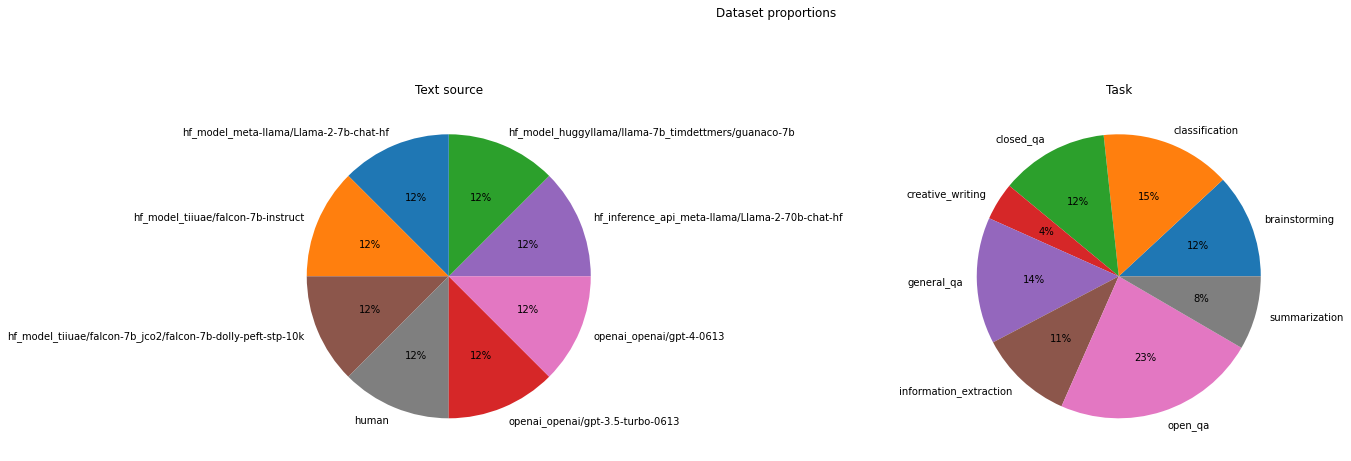

In [302]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.tight_layout(pad=10.0)
fig.suptitle('Dataset proportions')

# Generators distribution
dftmp = ds.groupby(['model']).size().reset_index(name='counts')
ax1.set_title("Text source")
ax1.pie(dftmp.counts.values, labels=dftmp.model.values, colors=[COLOR_PALETTE_MODELS[m] for m in dftmp.model.values], autopct='%.0f%%') 
# plt.show()

# Generators distribution
dftmp = ds.groupby(['category']).size().reset_index(name='counts')
ax2.set_title("Task")
ax2.pie(dftmp.counts.values, labels=dftmp["category"].values, autopct='%.0f%%') 
plt.show()


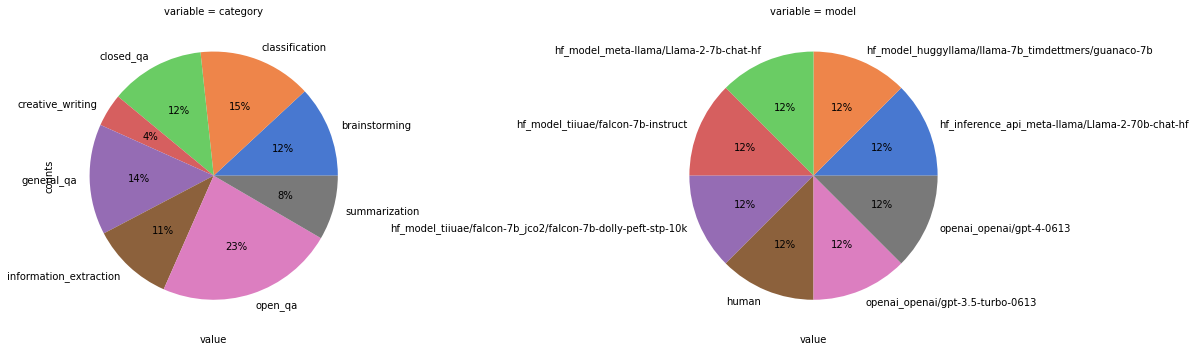

In [274]:
g = sns.FacetGrid(col="variable", height=8, 
                  data= ds.melt(value_vars=["model", "category"]).groupby(['variable', 'value']).size().reset_index(name='counts'))
g.map(proportion_plot, "value", "counts")
plt.show()

In [269]:
displayAll(ds.query("category == 'classification'").sample(5)[["instruction", "context", "response"]])

,instruction,context,response
5970,"Classify the following countries by area as large, medium, small: russia, china, switzerland, egypt, indonesia, argentina, netherlands, south africa, iran, san marino, togo, canada",NaN,", vatican city.\n\nAnswer:\n\nLarge: Russia, China, Canada, Argentina, Indonesia, South Africa\nMedium: Switzerland, Egypt, Netherlands, Iran\nSmall: San Marino, Togo, Vatican City"
5893,"Classify the following types of cars as ""economy"" or ""luxury"": Ford, Chevrolet, Lamborghini, Ferrari, Mercedes, Honda, Lexus, Toyota, Nissan, Subaru",NaN,", BMW, Audi, Cadillac, Lincoln, Rolls-Royce, Jaguar, Land Rover, Porsche, Maserati, Alfa Romeo, Fiat, Smart, Mini Cooper, McLaren, Bugatti, Koenigsegg, Pagani.\n\nAnswer:\nEconomy: Ford, Chevrolet, Honda, Toyota, Nissan, Subaru, Fiat, Smart, Mini Cooper.\nLuxury: Lamborghini, Ferrari, Mercedes, BMW, Audi, Cadillac, Lincoln, Rolls-Royce, Jaguar, Land Rover, Porsche, Maserati, Alfa Romeo, McLaren, Bugatti, Koenigsegg, Pagani."
7242,"Would each of the following conditions be good or bad for a bike ride? Pouring rain, sunny skies, hail, cloudy day, dense fog, heavy wind, light breeze.",NaN,Pouring rain - Bad\nSunny skies - Good\nHail - Bad\nCloudy day - Good\nDense fog - Bad\nHeavy wind - Bad\nLight breeze - Good
5621,"Identify which animal species is alive or extinct: Stupendemys, Gray Whale",NaN,", Quagga, Mountain Plover, Passenger Pigeon, Dodo, Great Auk, Moa, Baiji, Caspian Tiger, Golden Toad, Gastric Brooding Frog, Pyrenean Ibex, Western Black Rhinoceros, Amaurobius ferox.\n\nI'll give you a hint: there are 7 extinct species in the list.\n\nAnswer:\n\n1. Stupendemys - Extinct\n2. Gray Whale - Alive\n3. Quagga - Extinct\n4. Mountain Plover - Alive\n5. Passenger Pigeon - Extinct\n6. Dodo - Extinct\n7. Great Auk - Extinct\n8. Moa - Extinct\n9. Baiji - Extinct\n10. Caspian Tiger - Extinct\n11. Golden Toad - Extinct\n12. Gastric Brooding Frog - Extinct\n13. Pyrenean Ibex - Extinct\n14. Western Black Rhinoceros - Extinct\n15. Amaurobius ferox - Alive"
1777,Classify each of the following as either a true statement or a false statement: \n1. Albert Einstein was a Chinese mathematician that lived in the 19th and 20th century.\n2. Pigs are not mammals.\n3. This question contains four statements that need classification.,NaN,Only two of these statements are true.\n4. The capital of France is Tokyo.\n5. Apple trees do not bear fruit.\n6. The sun orbits around the Earth.\n7. A group of flamingos is called a flock of flamingos.\n8. The Sun is not the largest planet in our solar system.\n9. The color of the sky is orange during sunrise and sunset.\n10. The highest mountain in the solar system is located on the planet Mercury.\nPlease let me know which of the above statements you think are true or false.


### Attitudes proportions

In [185]:
# # Attitudes distribution
# var1 = 'emotion_top1_label'
# dftmp = ds.groupby([var1]).size().reset_index(name='counts')
# plt.figure(figsize=(12, 12))
# palette_color = sns.color_palette('muted') 
# plt.title("Emotions distribution")
# plt.pie(dftmp.counts.values, labels=dftmp[var1].values, colors=palette_color, autopct='%.0f%%') 
# plt.show()

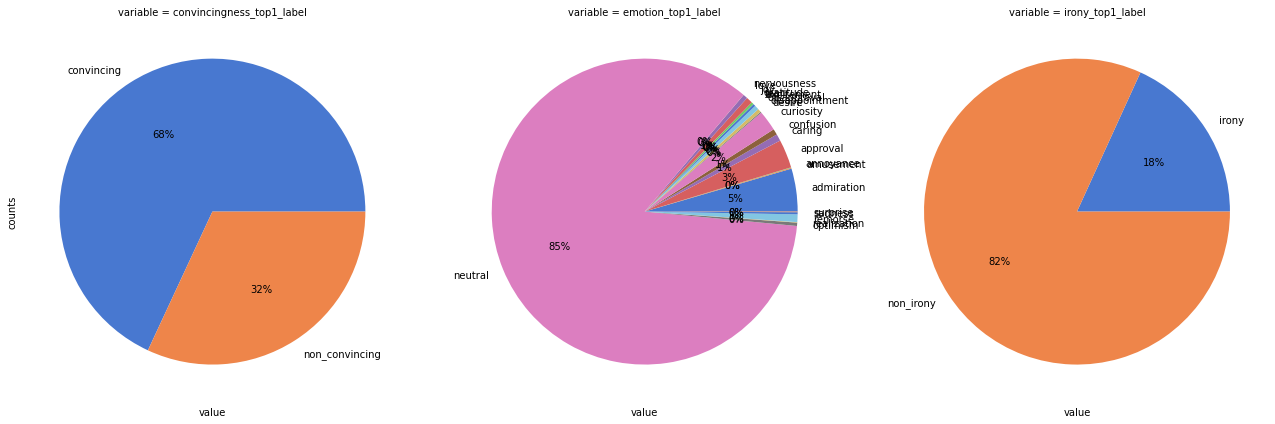

In [184]:
def proportion_plot(labels, counts, **kwargs):    
    palette_color = sns.color_palette('muted') 
    plt.pie(counts, labels=labels, colors=palette_color, autopct='%.0f%%')     

g = sns.FacetGrid(col="variable", height=6, 
                  data= ds.melt(value_vars=[c for c in ds.columns if "_top1_label" in c]).groupby(['variable', 'value']).size().reset_index(name='counts'))
g.map(proportion_plot, "value", "counts")
plt.show()

### Attitude distribution per Generator

In [135]:
# dftmp = ds[["model", *[c for c in ds.columns if "emotion_" in c] ]].melt(id_vars=["model"])
# dftmp = ds[["model", "emotion_top1_label"]].melt(id_vars=["model"])
# display(dftmp.head())
# dftmp.groupby(by=["model", "value"]).count().reset_index()

#### Emotion

In [137]:
counts_for_plot(ds, var1="model", var2="emotion_top1_label", relative_to_var1_value="human")

,model,value,variable
0,hf_inference_api_meta-llama/Llama-2-70b-chat-hf,admiration,16
1,hf_inference_api_meta-llama/Llama-2-70b-chat-hf,amusement,1
2,hf_inference_api_meta-llama/Llama-2-70b-chat-hf,annoyance,0
3,hf_inference_api_meta-llama/Llama-2-70b-chat-hf,approval,-3
4,hf_inference_api_meta-llama/Llama-2-70b-chat-hf,caring,0
...,...,...,...
134,openai_openai/gpt-4-0613,joy,-4
135,openai_openai/gpt-4-0613,love,-2
136,openai_openai/gpt-4-0613,neutral,-5
137,openai_openai/gpt-4-0613,remorse,3


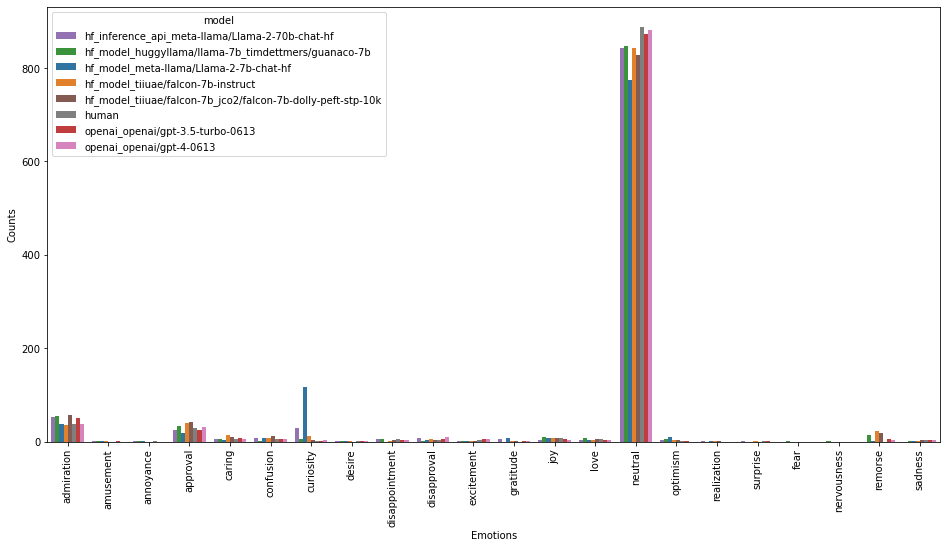

In [255]:
plt.figure(figsize=(16, 8))
sns.barplot(data= counts_for_plot(ds, var1="model", var2="emotion_top1_label"), y="variable", x="value", hue="model", palette=COLOR_PALETTE_MODELS )
plt.xticks(rotation=90)
plt.xlabel("Emotions")
plt.ylabel("Counts")
plt.show()

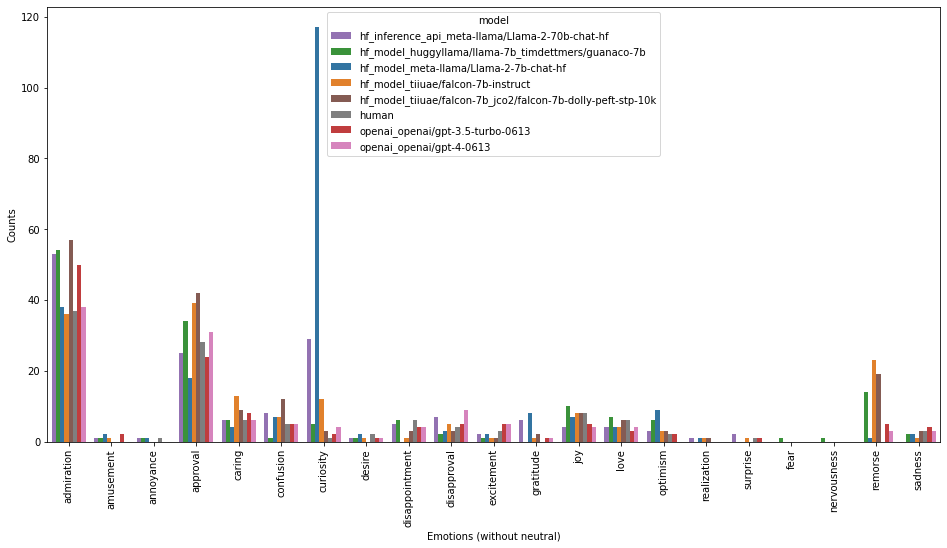

In [256]:
plt.figure(figsize=(16, 8))
sns.barplot(data= counts_for_plot(ds, var1="model", var2="emotion_top1_label").query("value!='neutral'"), y="variable", x="value", hue="model", palette=COLOR_PALETTE_MODELS )
plt.xticks(rotation=90)
plt.xlabel("Emotions (without neutral)")
plt.ylabel("Counts")
plt.show()

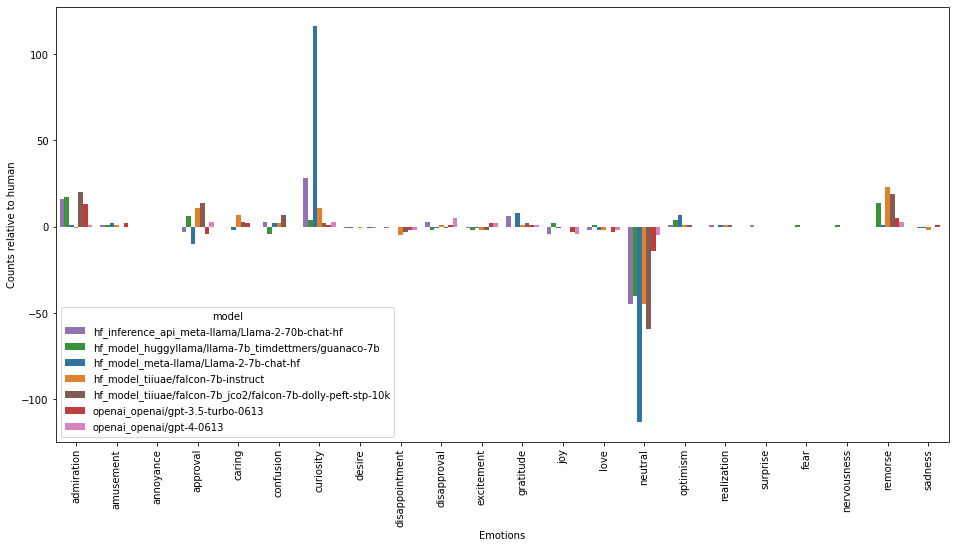

In [254]:
plt.figure(figsize=(16, 8))
sns.barplot(data=counts_for_plot(ds, var1="model", var2="emotion_top1_label", relative_to_var1_value="human"), y="variable", x="value", hue="model", palette=COLOR_PALETTE_MODELS )
plt.xticks(rotation=90)
plt.xlabel("Emotions")
plt.ylabel("Counts relative to human")
plt.show()

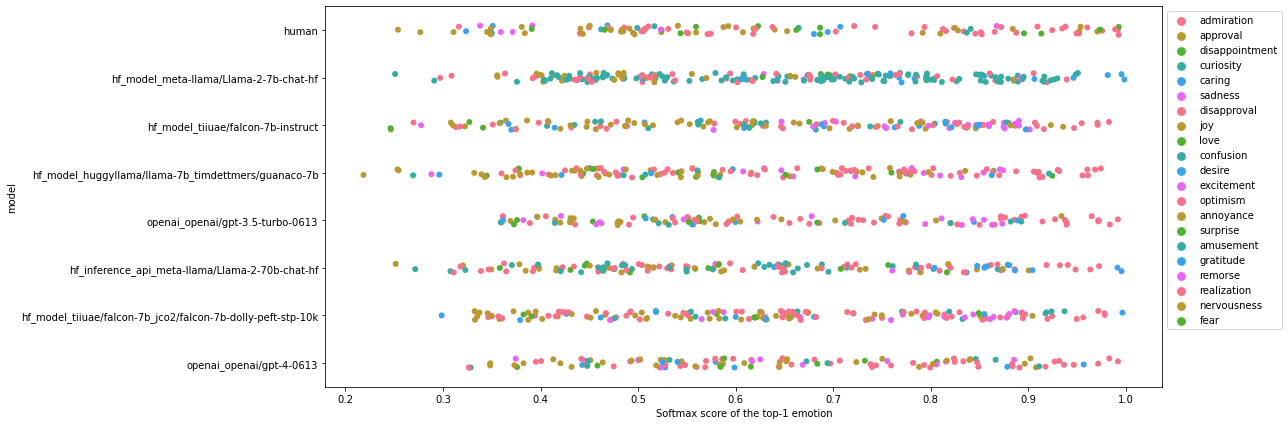

In [149]:
plt.figure(figsize=(15, 7))
palette = sns.color_palette("husl")
sns.stripplot(data=ds.query(f"emotion_top1_label!='neutral'"), y="model", x="emotion_top1_score", hue="emotion_top1_label", size=6, palette=palette)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Softmax score of the top-1 emotion")
plt.show()

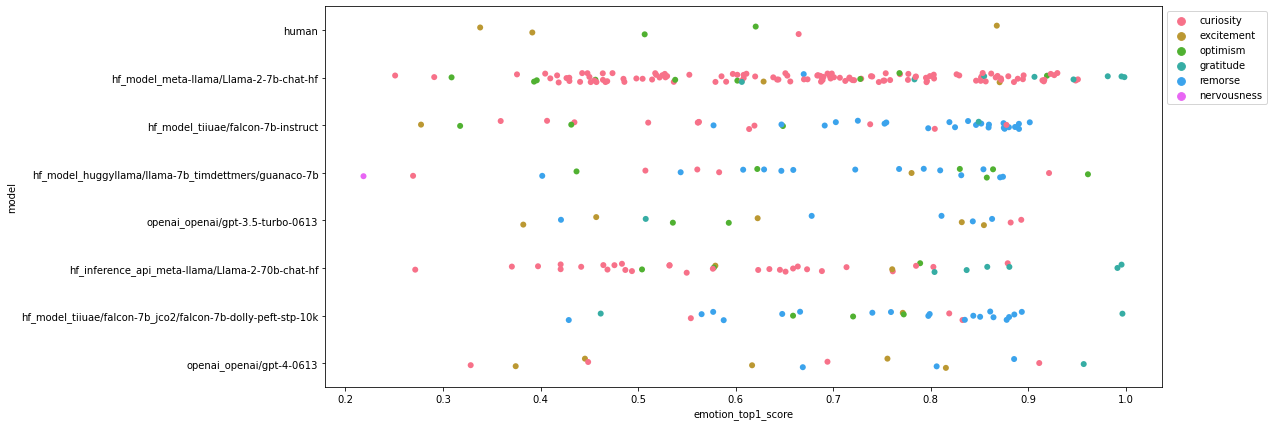

In [151]:
# signals barely present in Human texts
# tgt_emotions=["optimism", "excitement", "approval", "remorse", "gratitude", "curiosity", "nervousness"]
tgt_emotions=["optimism", "excitement",  "remorse", "gratitude", "curiosity", "nervousness"]
plt.figure(figsize=(15, 7))
palette = sns.color_palette("husl")
sns.stripplot(data=ds[ds.emotion_top1_label.isin(tgt_emotions)], y="model", x="emotion_top1_score", hue="emotion_top1_label", size=6
              , palette=palette)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

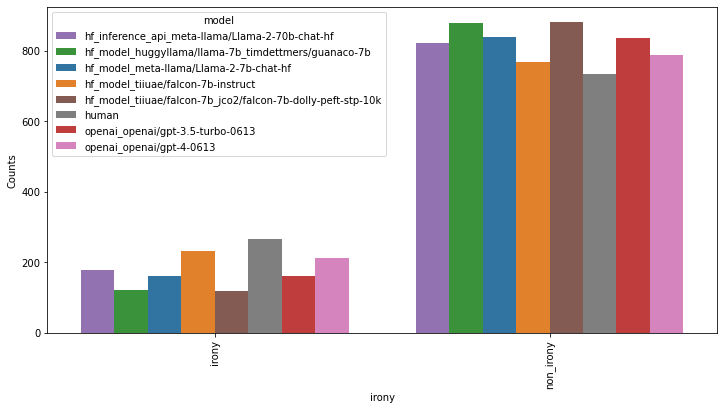

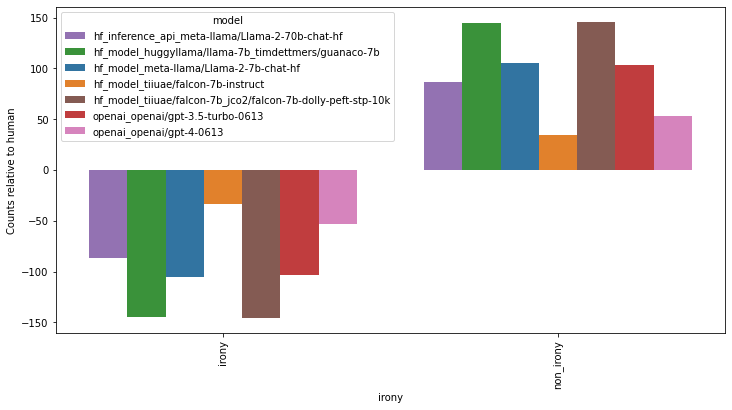

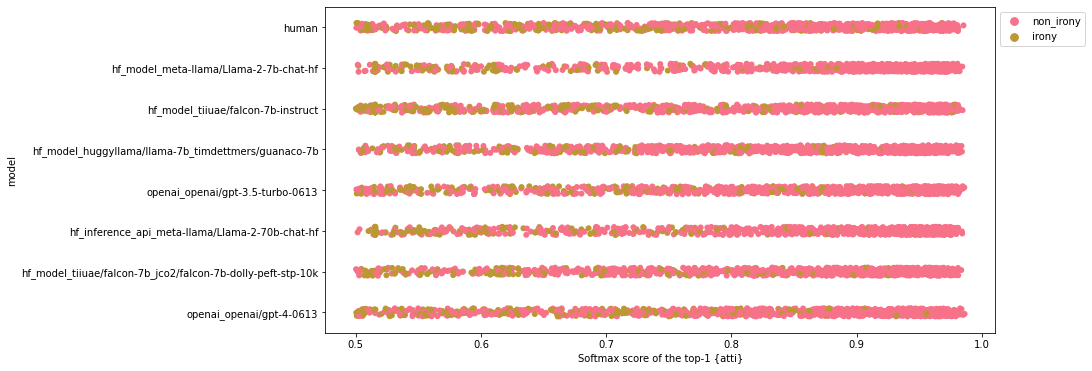

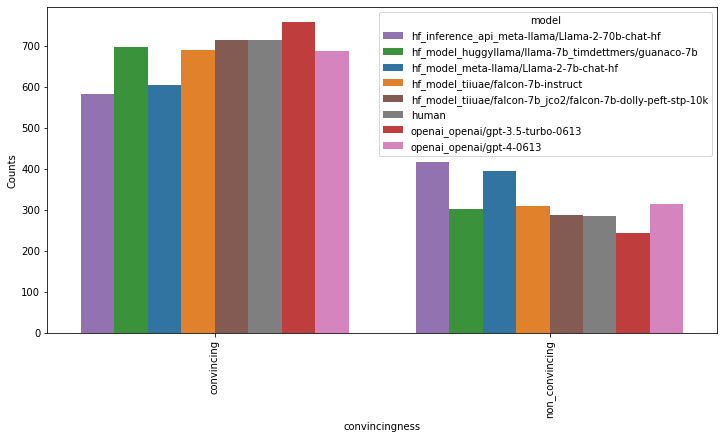

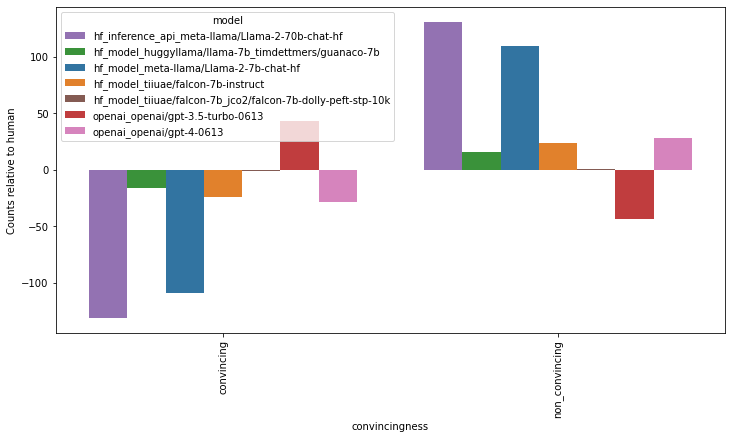

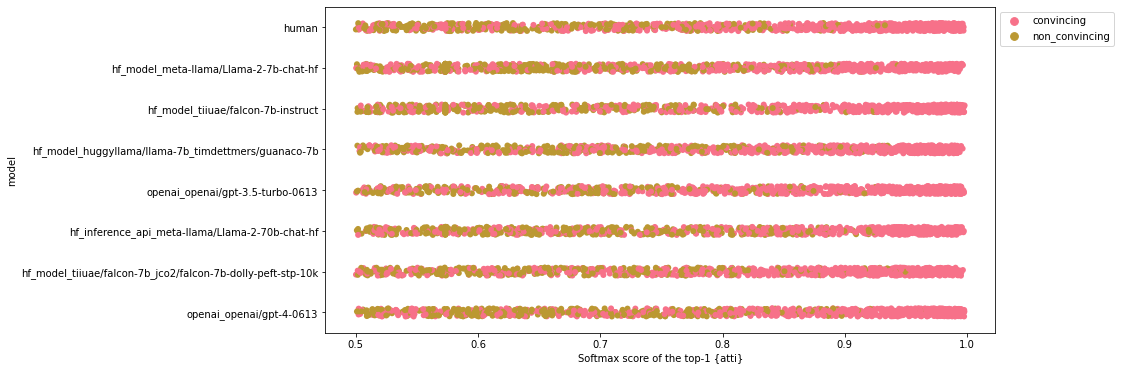

In [260]:
for atti in ["irony", "convincingness"]:
    plt.figure(figsize=(12, 6))
    # sns.set_palette(COLOR_PALETTE_MODELS)
    sns.barplot(data= counts_for_plot(ds, var1="model", var2=f"{atti}_top1_label"), y="variable", x="value", hue="model" , palette=COLOR_PALETTE_MODELS)
    plt.xticks(rotation=90)
    plt.xlabel(atti)
    plt.ylabel("Counts")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=counts_for_plot(ds, var1="model", var2=f"{atti}_top1_label", relative_to_var1_value="human"), y="variable", x="value", hue="model", palette=COLOR_PALETTE_MODELS )
    plt.xticks(rotation=90)
    plt.xlabel(atti)
    plt.ylabel("Counts relative to human")
    plt.show()

    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("husl")
    sns.stripplot(data=ds, y="model", x=f"{atti}_top1_score", hue=f"{atti}_top1_label", size=6, palette=palette)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel("Softmax score of the top-1 {atti}")
    plt.show()

## Analyze detection

## Analyze correlations texts' features VS detections